In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machademy-data/data.csv


Missing Values:
 zone1_temperature               949
zone2_temperature               923
equipment_energy_consumption    912
zone1_humidity                  888
zone9_humidity                  888
zone3_humidity                  878
zone2_humidity                  867
lighting_energy                 864
zone6_temperature               848
zone8_temperature               848
zone6_humidity                  847
atmospheric_pressure            842
zone5_temperature               838
wind_speed                      828
dew_point                       826
random_variable1                826
random_variable2                824
zone4_temperature               816
visibility_index                815
outdoor_temperature             806
zone7_humidity                  805
zone3_temperature               802
zone5_humidity                  801
outdoor_humidity                799
zone7_temperature               794
zone4_humidity                  781
zone8_humidity                  777
zone9_tempe

/tmp/ipykernel_31/1443036096.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_31/1443036096.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


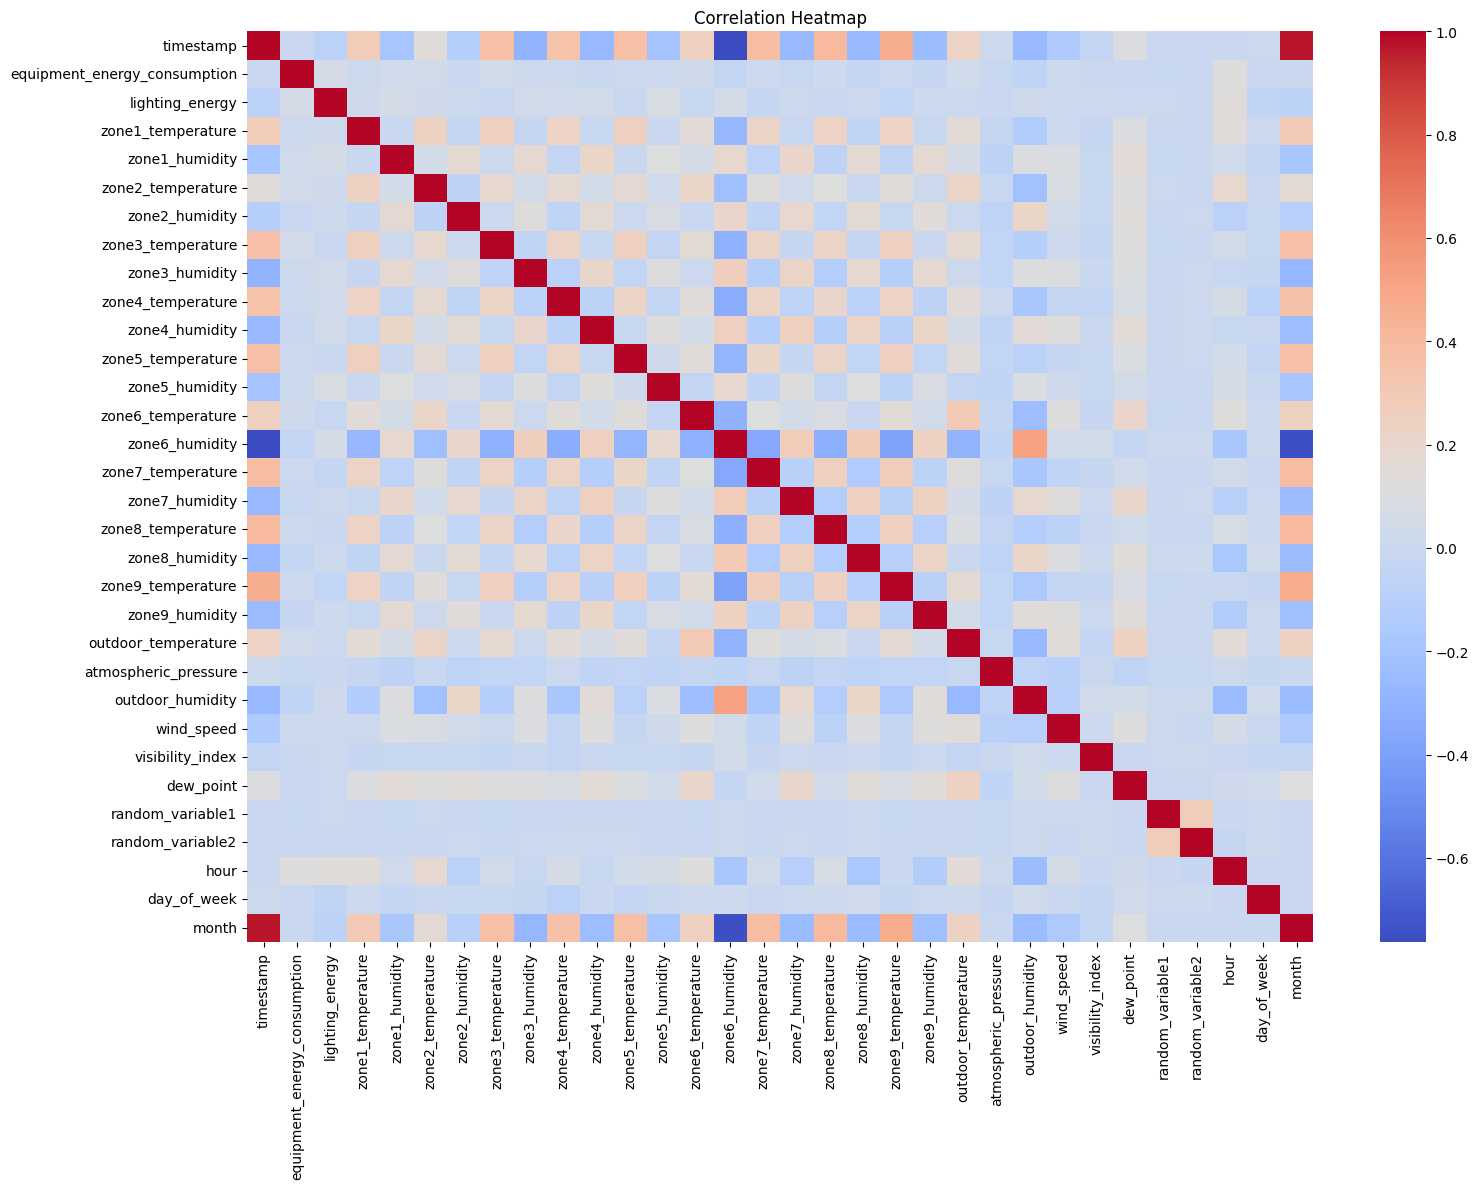

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


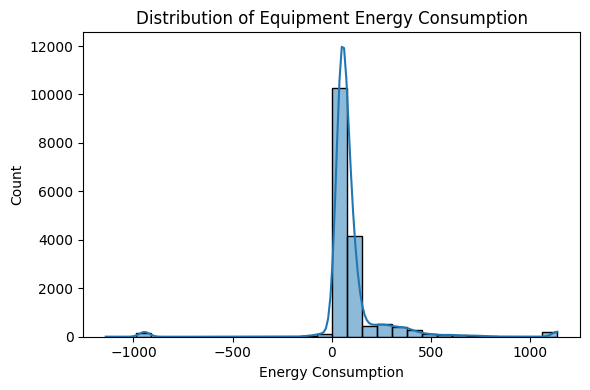

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/kaggle/input/machademy-data/data.csv")

# 1. Convert timestamp column
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Convert object columns to float (except timestamp)
for col in df.columns:
    if df[col].dtype == 'object' and col != 'timestamp':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Check for missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
print("Missing Values:\n", missing_summary)

# 4. Impute missing values using forward fill then backfill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# 5. Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# 6. Cap outliers in humidity (valid range: 0-100)
humidity_cols = [col for col in df.columns if 'humidity' in col]
for col in humidity_cols:
    df[col] = df[col].clip(lower=0, upper=100)

# 7. Remove or cap negative values in features like wind_speed
df['wind_speed'] = df['wind_speed'].clip(lower=0)

# 8. Plot correlation heatmap (optional for EDA)
plt.figure(figsize=(16, 12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# 9. Plot target distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['equipment_energy_consumption'], bins=30, kde=True)
plt.title("Distribution of Equipment Energy Consumption")
plt.xlabel("Energy Consumption")
plt.tight_layout()
plt.show()


# Correlation Analysis

In [5]:
correlation_rv = df[['random_variable1', 'random_variable2', 'equipment_energy_consumption']].corr()
print(correlation_rv)


                              random_variable1  random_variable2  \
random_variable1                      1.000000          0.271798   
random_variable2                      0.271798          1.000000   
equipment_energy_consumption         -0.015433         -0.009937   

                              equipment_energy_consumption  
random_variable1                                 -0.015433  
random_variable2                                 -0.009937  
equipment_energy_consumption                      1.000000  


# Feature Importance from Tree-Based Models

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df.drop(columns=['timestamp', 'equipment_energy_consumption'])
y = df['equipment_energy_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances[['random_variable1', 'random_variable2']])


random_variable1    0.03444
random_variable2    0.03409
dtype: float64


# Model Performance Comparision (with or without)

In [7]:
from sklearn.metrics import mean_squared_error

# With random variables
X_full = df.drop(columns=['timestamp', 'equipment_energy_consumption'])
X_red = X_full.drop(columns=['random_variable1', 'random_variable2'])

# Train-test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, random_state=42)
X_train_red, X_test_red, _, _ = train_test_split(X_red, y, random_state=42)

# Train both models
model_full = RandomForestRegressor(random_state=42).fit(X_train_full, y_train)
model_red = RandomForestRegressor(random_state=42).fit(X_train_red, y_train)

# Compare RMSE
rmse_full = mean_squared_error(y_test, model_full.predict(X_test_full), squared=False)
rmse_red = mean_squared_error(y_test, model_red.predict(X_test_red), squared=False)

print(f"RMSE with random vars: {rmse_full:.4f}")
print(f"RMSE without random vars: {rmse_red:.4f}")


RMSE with random vars: 175.5586
RMSE without random vars: 175.7253


# PCA to evaluate the contribution of random_variable1 and random_variable2

Top loadings for PC1 and PC2:
                       PC1       PC2
random_variable1 -0.006156 -0.011365
random_variable2 -0.007870  0.000216


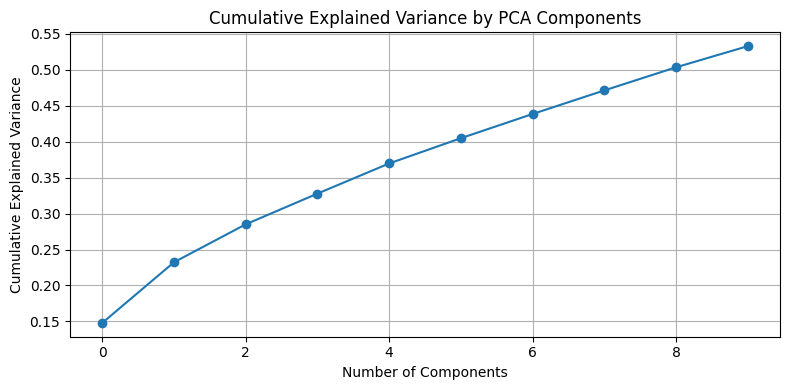

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-numeric and target columns
features = df.drop(columns=['timestamp', 'equipment_energy_consumption'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=10)  # Get first 10 components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame of component loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=features.columns)

# Display how much each feature contributes to the first few principal components
print("Top loadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']].loc[['random_variable1', 'random_variable2']])

# Scree plot of explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Development

Important Features using Random Forest and Recursive Feature Elimination 

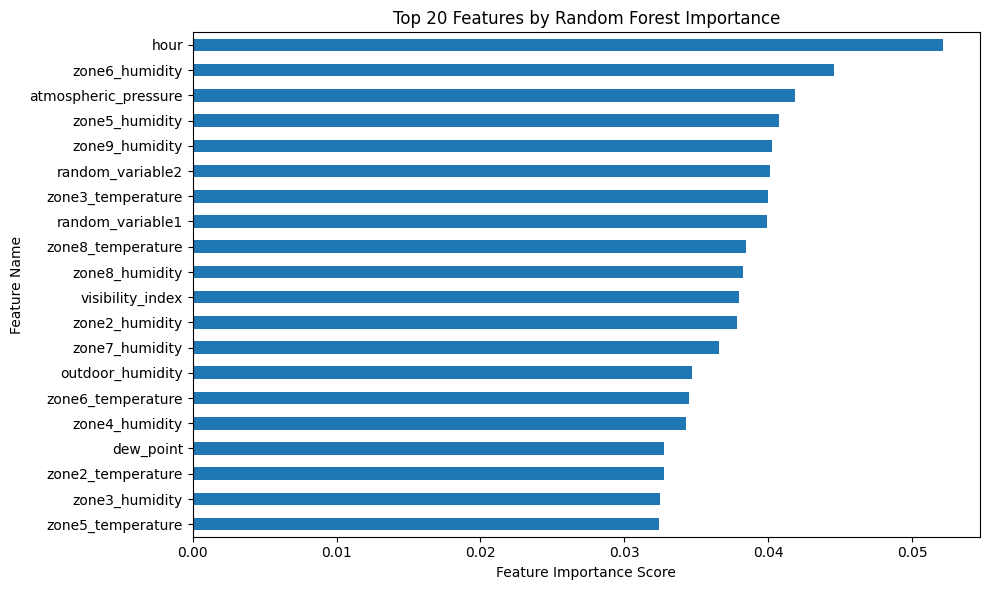


Running RFE (selecting top 15 features)...


Eliminating from 16 features:  94%|█████████▍| 15/16 [00:02<00:00,  6.19it/s]


 Top Features Selected by Manual RFE:
 ['zone1_humidity', 'zone2_temperature', 'zone2_humidity', 'zone3_temperature', 'zone4_humidity', 'zone5_humidity', 'zone6_temperature', 'zone6_humidity', 'zone8_temperature', 'zone9_humidity', 'atmospheric_pressure', 'outdoor_humidity', 'dew_point', 'random_variable1', 'hour']


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv("/kaggle/input/machademy-data/data.csv")

# Convert timestamp and fix numeric columns
df['timestamp'] = pd.to_datetime(df['timestamp'])
for col in df.columns:
    if df[col].dtype == 'object' and col != 'timestamp':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.ffill(inplace=True)
df.bfill(inplace=True)

# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Prepare features and target
X = df.drop(columns=['timestamp', 'equipment_energy_consumption'])
y = df['equipment_energy_consumption']

# ----------------------------
# Feature Importance Plot
# ----------------------------
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False)

# Plot with axis labels
plt.figure(figsize=(10, 6))
top_importances.head(20).plot(kind='barh')
plt.title("Top 20 Features by Random Forest Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ----------------------------
# Manual RFE with tqdm
# ----------------------------
features = list(X.columns)
n_features_to_select = 15

print(f"\nRunning RFE (selecting top {n_features_to_select} features)...")

while len(features) > n_features_to_select:
    with tqdm(total=len(features), desc=f"Eliminating from {len(features)} features") as pbar:
        rf_temp = clone(rf)
        rf_temp.fit(X[features], y)
        importances = pd.Series(rf_temp.feature_importances_, index=features)
        least_important = importances.idxmin()
        features.remove(least_important)
        pbar.update(len(features))

selected_features = features
print("\n Top Features Selected by Manual RFE:\n", selected_features)


In [ ]:
print(selected_features)
print("hii")

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# Load and preprocess
df = pd.read_csv("/kaggle/input/machademy-data/data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

for col in df.columns:
    if df[col].dtype == 'object' and col != 'timestamp':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.ffill(inplace=True)
df.bfill(inplace=True)

# Time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Target and selected features
y = df['equipment_energy_consumption']
# selected_features = [
#     'zone2_humidity', 'zone5_temperature', 'outdoor_temperature', 'dew_point',
#     'zone4_humidity', 'zone3_temperature', 'zone9_temperature', 'atmospheric_pressure',
#     'lighting_energy', 'zone2_temperature', 'zone3_humidity', 'zone6_temperature',
#     'zone5_humidity', 'wind_speed', 'hour'
# ]
X = df[selected_features]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid = list(ParameterGrid(param_grid))
print(f"Total combinations: {len(grid)}")

# Progress bar with manual grid search
best_rmse = float('inf')
best_model = None
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Final predictions
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results
print("\n Best Hyperparameters:")
print(best_params)
print("\n Model Evaluation:")
print(f"RMSE: {best_rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


# DL Approach

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load and preprocess
df = pd.read_csv("/kaggle/input/machademy-data/data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

for col in df.columns:
    if df[col].dtype == 'object' and col != 'timestamp':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.ffill(inplace=True)
df.bfill(inplace=True)

# Time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Selected features from RFE
selected_features = [
    'zone2_humidity', 'zone5_temperature', 'outdoor_temperature', 'dew_point',
    'zone4_humidity', 'zone3_temperature', 'zone9_temperature', 'atmospheric_pressure',
    'lighting_energy', 'zone2_temperature', 'zone3_humidity', 'zone6_temperature',
    'zone5_humidity', 'wind_speed', 'hour'
]
X = df[selected_features]
y = df['equipment_energy_consumption']

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track losses
train_losses = []
test_losses = []

# Training loop
epochs = 50
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for batch_X, batch_y in loop:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Evaluate test loss
    model.eval()
    with torch.no_grad():
        test_output = model(X_test_tensor)
        test_loss = criterion(test_output, y_test_tensor).item()
        test_losses.append(test_loss)
    model.train()

    print(f"Epoch {epoch+1} - Train Loss: {epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

rmse = mean_squared_error(y_true, preds, squared=False)
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print("\n✅ PyTorch MLP Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
